In [1]:
import warnings

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler


warnings.simplefilter('ignore')

In [20]:
df = pd.read_csv('data.csv')
df.head(3)

data = df['num_fruits'].values
num_tree = len(data)

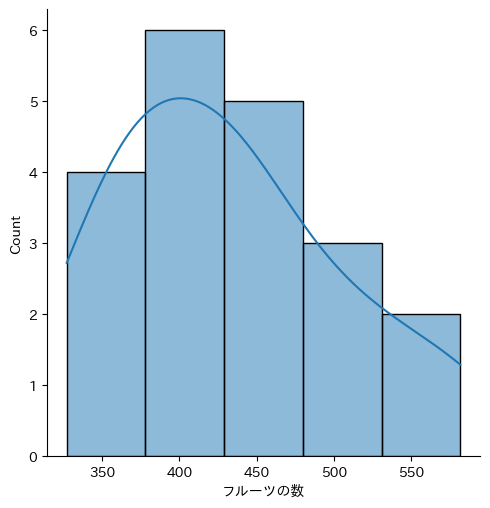

In [17]:
sns.displot(x=data, kde=True, binwidth=50)
plt.xlabel('フルーツの数')
plt.show()

In [19]:
data.mean(), data.var()

(431.15, 5095.0275)

平均≠分散(過分散)のため個体値が無視できないことが分かる<br>
一般化線形混合モデルでポアソン回帰を行う<br>
<span style="color: red; ">観測できない要素を"個体差"としてモデルに組み込む</span>

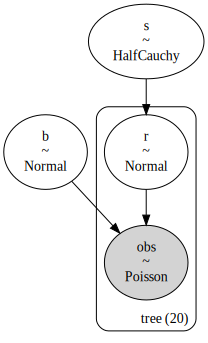

In [93]:
model = pm.Model()


with model:
    model.add_coord('tree', values=df.index, mutable=True)
    b = pm.Normal('b', mu=0, sigma=10)
    s = pm.HalfCauchy('s', beta=5)
    r = pm.Normal('r', mu=0, sigma=s, dims='tree')
    
    theta = b + r
    mu = pm.math.exp(theta)
    obs = pm.Poisson('obs', mu=mu, observed=data, dims='tree')

pm.model_to_graphviz(model)

In [95]:
with model:
    iter = pm.sample(6000, tune=3000, idata_kwargs={'log_likelihood': True})
    iter.extend(pm.sample_posterior_predictive(iter, random_seed=8931))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, s, r]


Output()

Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 6 seconds.
Sampling: [obs]


Output()

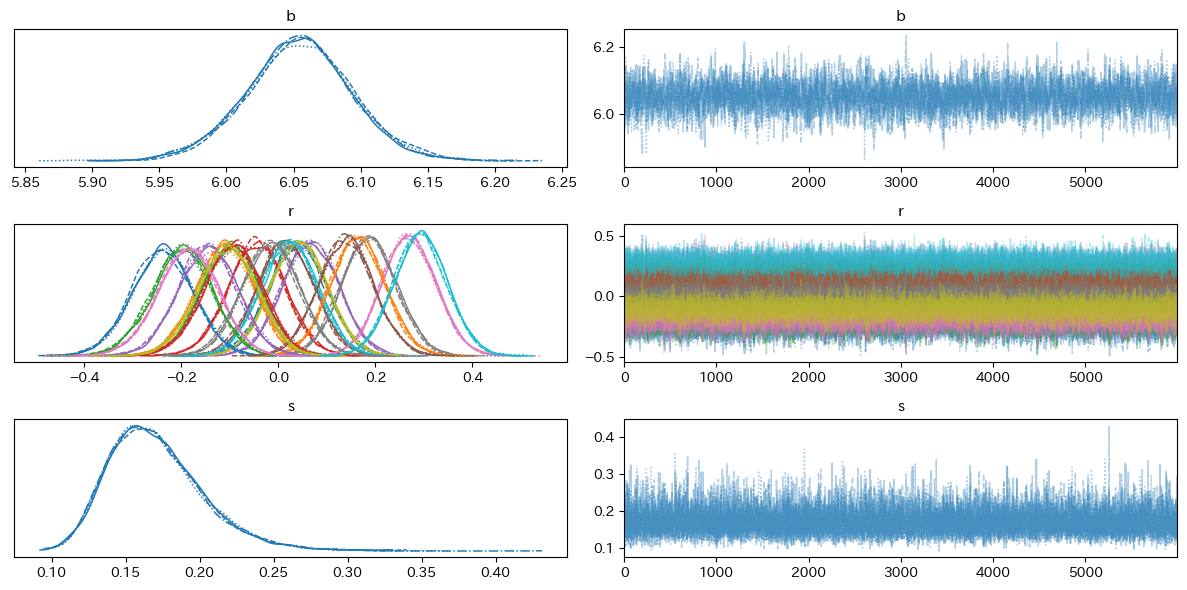

In [29]:
az.plot_trace(iter)
plt.tight_layout()
plt.show()

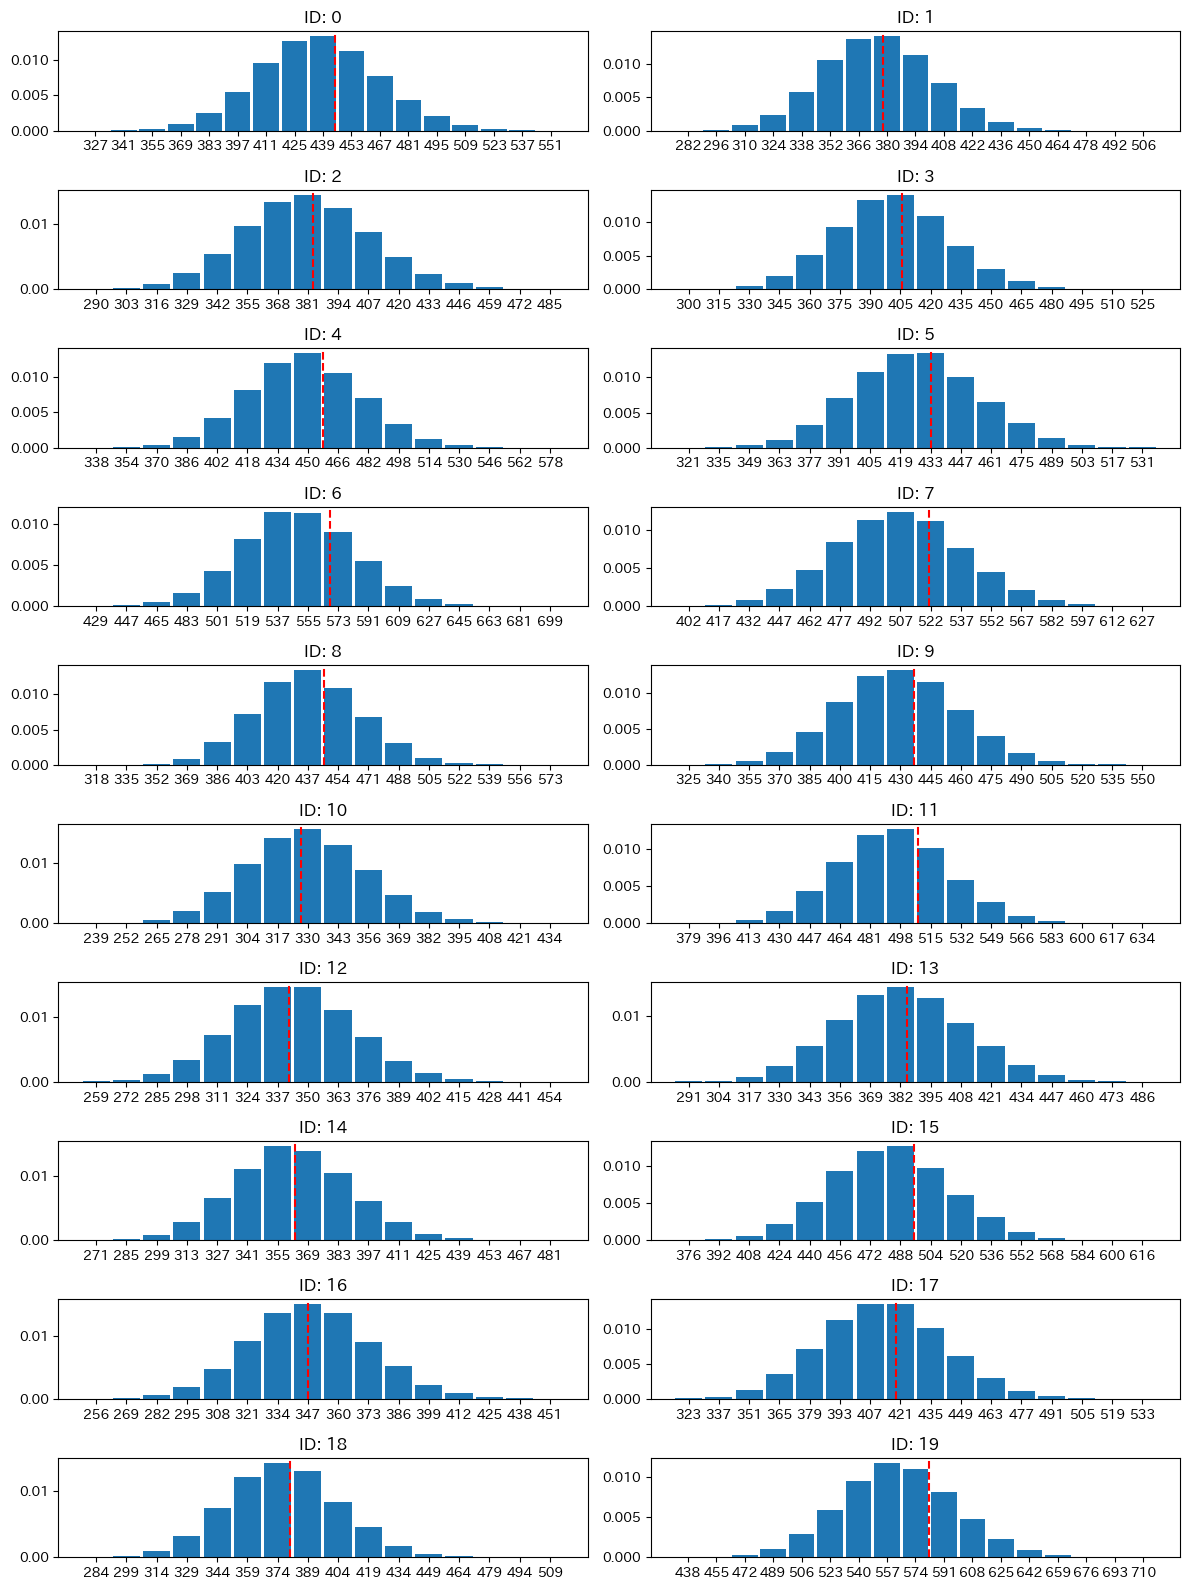

In [40]:
figure = plt.figure(figsize=[12, 16])


for k in range(num_tree):
    ax = figure.add_subplot(10, 2, k+1)
    az.plot_dist(iter.posterior_predictive['obs'][:, :, k].values.flatten())
    ax.axvline(data[k], color='r', linestyle='dashed')
    ax.set_title(f'ID: {k}')

plt.tight_layout()
plt.show()

概ね推定分布がデータの値(赤線)と同じで、精度良く推定できている<br>
ランダム効果(個体差)も確認しておく

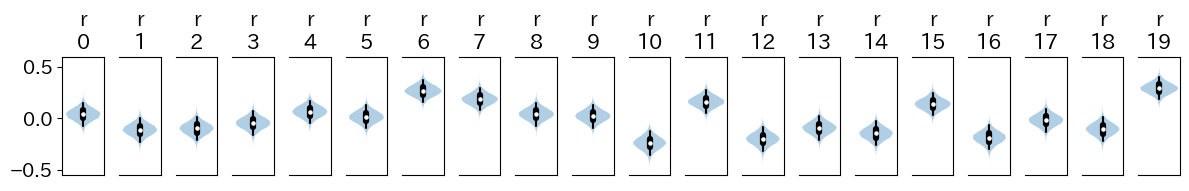

In [49]:
az.plot_violin(iter.posterior['r'], grid=(1, num_tree), figsize=(12, 2))
plt.tight_layout()
plt.show()

## データにSpan(木の成長度合い)を追加してみた

In [85]:
df_updated = pd.read_csv('data_updated.csv')

spans = df_updated['span'].values
spans_scaled = StandardScaler().fit_transform(spans.reshape(-1, 1)).flatten()
spans

array([4.5, 3.8, 3.7, 4.2, 4.5, 4.1, 4.2, 4.5, 3.9, 4. , 3.2, 3.9, 3. ,
       4.1, 3.7, 4.9, 4.3, 4. , 3.1, 4.8])

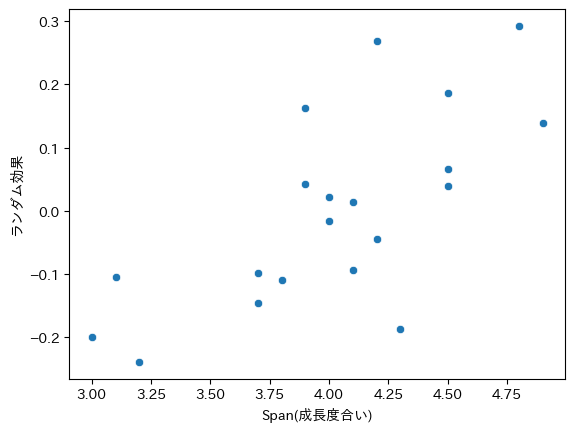

In [81]:
sns.scatterplot(x=spans, y=iter.posterior.r.mean(axis=(0, 1)).values)
plt.xlabel('Span(成長度合い)')
plt.ylabel('ランダム効果')
plt.show()

追加で取得したSpanデータがランダム効果を表していそうなので、モデルを改良する

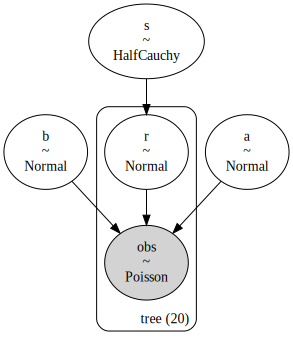

In [96]:
model_span = pm.Model()


with model_span:
    model_span.add_coord('tree', values=df.index, mutable=True)
    
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10)
    s = pm.HalfCauchy('s', beta=5)
    r = pm.Normal('r', mu=0, sigma=s, dims='tree')
    
    theta = a * spans_scaled + b + r
    mu = pm.math.exp(theta)
    obs = pm.Poisson('obs', mu=mu, observed=data, dims='tree')

pm.model_to_graphviz(model_span)

In [97]:
with model_span:
    iter_span = pm.sample(6000, tune=3000, idata_kwargs={'log_likelihood': True})
    iter_span.extend(pm.sample_posterior_predictive(iter_span, random_seed=8931))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s, r]


Output()

Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 6 seconds.
Sampling: [obs]


Output()

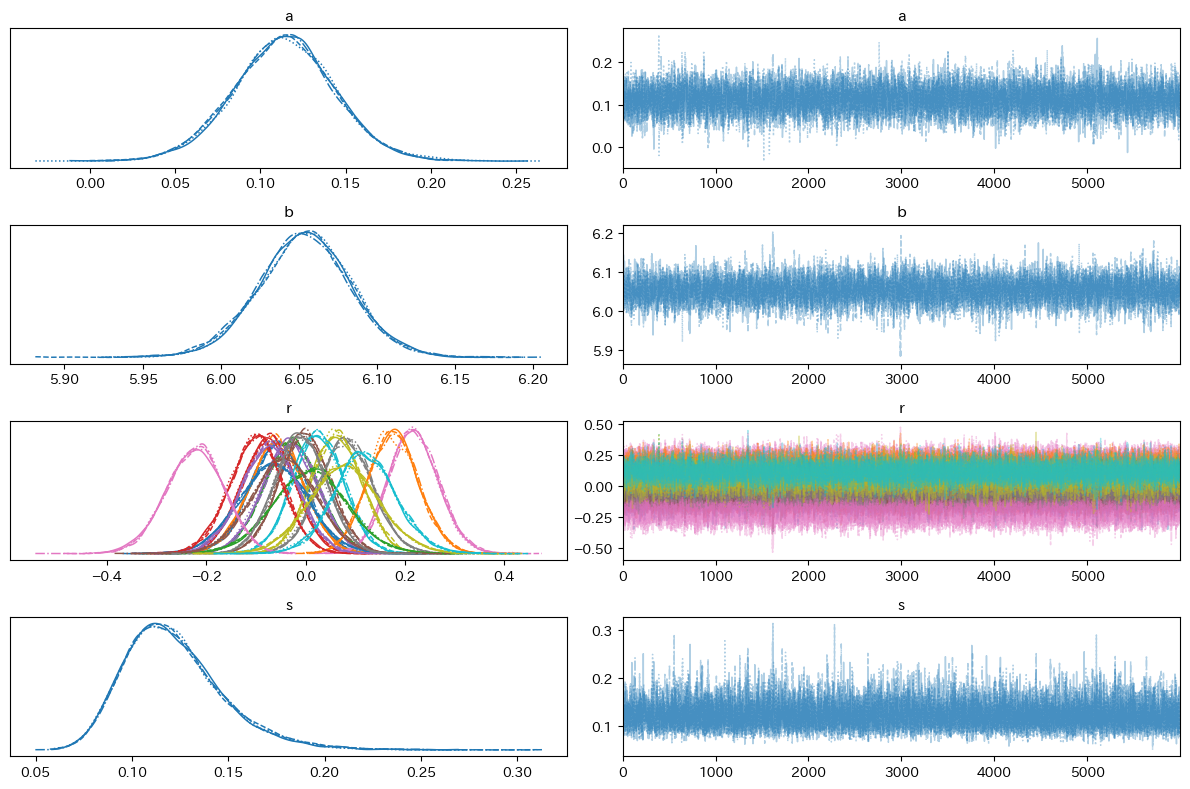

In [89]:
az.plot_trace(iter_span)
plt.tight_layout()
plt.show()

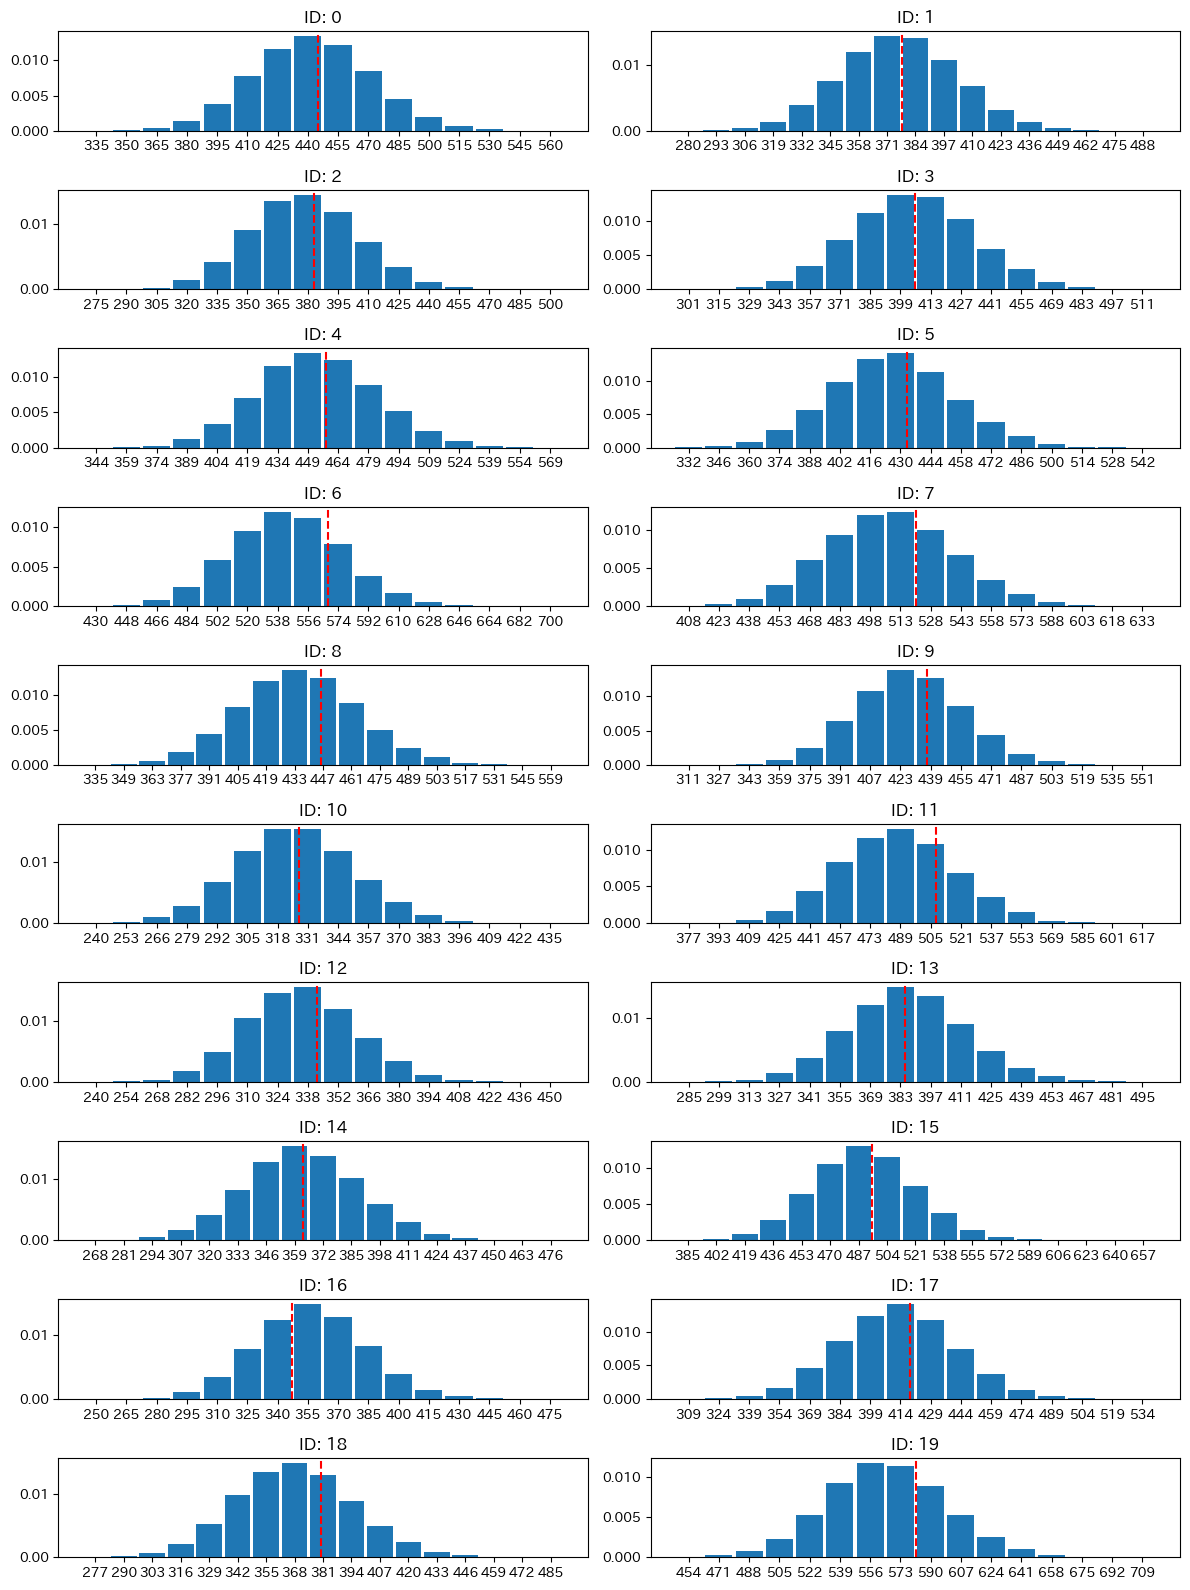

In [90]:
figure = plt.figure(figsize=[12, 16])


for k in range(num_tree):
    ax = figure.add_subplot(10, 2, k+1)
    az.plot_dist(iter_span.posterior_predictive['obs'][:, :, k].values.flatten())
    ax.axvline(data[k], color='r', linestyle='dashed')
    ax.set_title(f'ID: {k}')

plt.tight_layout()
plt.show()

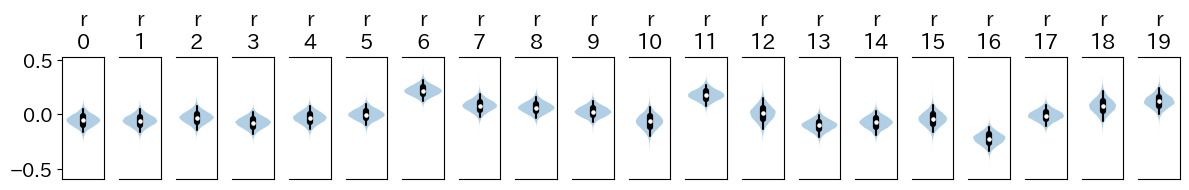

In [91]:
az.plot_violin(iter_span.posterior['r'], grid=(1, num_tree), figsize=(12, 2))
plt.tight_layout()
plt.show()

今回のモデルは木の成長度合いをモデルに追加したため、ランダム効果の出方は初めに作ったモデルとは少し違う

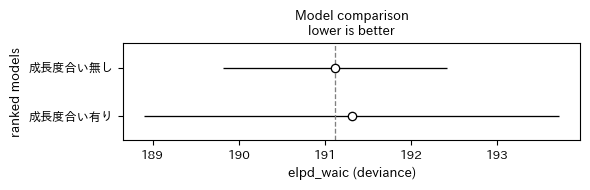

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
成長度合い無し,0,191.119206,9.734690,0.000000,0.584103,1.299421,0.000000,True,deviance
成長度合い有り,1,191.310011,9.797198,0.190805,0.415897,2.409816,1.882603,True,deviance


In [98]:
df_waic = az.compare({'成長度合い有り': iter_span, '成長度合い無し': iter}, ic='waic', scale='deviance')
az.plot_compare(df_waic)
plt.tight_layout()
plt.show()

df_waic